In [1]:
import pandas as pd
import torch
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments)
from transformers import BertForSequenceClassification
import numpy as np
from datasets import Dataset
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Celda 2: Configuración del modelo específico desde JSON
# 🎯 Cargar configuración del modelo desde archivo JSON

# Cargar parámetros desde JSON
with open(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\bert_params.json", "r") as f:
    all_params = json.load(f)

# Seleccionar dataset
dataset_type = "descripciones"  # Cambia a "codigos", "descripciones" o "combinado"

# Obtener configuración específica para el dataset
config = all_params[dataset_type]
model_name = config["model_name"]
learning_rate = config["learning_rate"]
batch_size = config["batch_size"]
epochs = config["epochs"]
weight_decay = config["weight_decay"]
warmup_ratio = config["warmup_ratio"]

print(f"🔧 Configuración del modelo cargada desde JSON:")
print(f"Modelo: {model_name}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Weight Decay: {weight_decay}")
print(f"Warmup Ratio: {warmup_ratio}")
print(f"Dataset: {dataset_type}")

🔧 Configuración del modelo cargada desde JSON:
Modelo: dccuchile/bert-base-spanish-wwm-uncased
Learning Rate: 5e-05
Batch Size: 32
Epochs: 3
Weight Decay: 0.01
Warmup Ratio: 0.1
Dataset: descripciones


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ✅ Carga de datos según el tipo de dataset
if dataset_type == "codigos":
    df = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv", sep="|")
    diag_cols = [col for col in df.columns if col.startswith("Diag")]
    df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
    df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "F20" in x and "F20.89" not in x else 0)
elif dataset_type == "descripciones":
    df = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv", sep="|")
    diag_cols = [col for col in df.columns if col.startswith("Diag")]
    df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
    df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "Esquizofrenia" in x and "Otros tipos de esquizofrenia" not in x else 0)
else:  # combinado
    df = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", sep="|")
    diag_cols = [col for col in df.columns if col.startswith("Diag")]
    df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
    df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "F20" in x and "F20.89" not in x else 0)

seed = int(time.time_ns() % (2**32))
np.random.seed(seed)

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], 
    stratify=df["label"], 
    test_size=0.2, 
    random_state=seed
)

train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

print("📊 Distribución de datos:")
print("Entrenamiento:", Counter(y_train))
print("Evaluación:", Counter(y_test))
print(f"Total ejemplos: {len(df)}")

Usando dispositivo: cuda
📊 Distribución de datos:
Entrenamiento: Counter({0: 1115, 1: 482})
Evaluación: Counter({0: 279, 1: 121})
Total ejemplos: 1997


Total ejemplos: 1997
Clases únicas: [0 1]


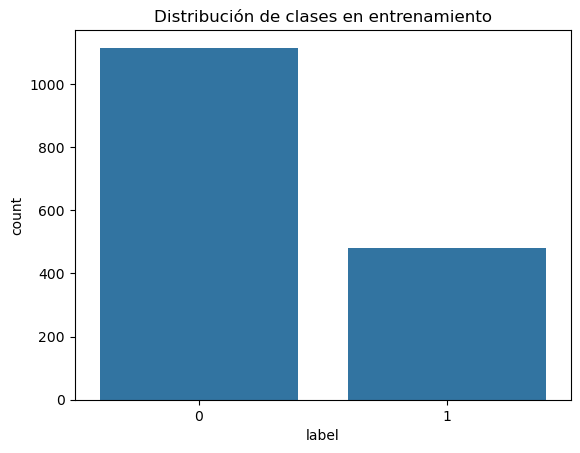

In [4]:
print(f"Total ejemplos: {len(df)}")
print(f"Clases únicas: {df['label'].unique()}")

sns.countplot(x=y_train)
plt.title("Distribución de clases en entrenamiento")
plt.show()

In [5]:
# Celda 5: Definición de funciones
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, zero_division=0),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0)
    }

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

In [6]:
# Celda 6: Entrenamiento del modelo
print(f"\n🚀 Iniciando entrenamiento del modelo: {model_name}")

# Cargar tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Tokenizar datasets
train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

# Cargar modelo
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Configurar argumentos de entrenamiento
output_dir = f"./results/{model_name.replace('/', '_')}_{dataset_type}"
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=seed
)

# Crear trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)

# Entrenar modelo
print("⏳ Entrenando modelo...")
trainer.train()


🚀 Iniciando entrenamiento del modelo: dccuchile/bert-base-spanish-wwm-uncased


Map: 100%|██████████| 400/400 [00:00<00:00, 11620.42 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⏳ Entrenando modelo...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.597800,0.563564,0.700000,0.600000,0.502793,0.743802
2,0.469100,0.393227,0.797500,0.643172,0.688679,0.603306
3,0.312200,0.409143,0.822500,0.689956,0.731481,0.652893


TrainOutput(global_step=150, training_loss=0.4596887715657552, metrics={'train_runtime': 1467.9867, 'train_samples_per_second': 3.264, 'train_steps_per_second': 0.102, 'total_flos': 315141266557440.0, 'train_loss': 0.4596887715657552, 'epoch': 3.0})

In [7]:
# Celda 7: Evaluación y resultados
print("\n📊 Evaluando modelo...")
metrics = trainer.evaluate()

print(f"\n🏆 Resultados finales:")
print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"F1-Score: {metrics['eval_f1']:.4f}")
print(f"Precision: {metrics['eval_precision']:.4f}")
print(f"Recall: {metrics['eval_recall']:.4f}")

# Crear resumen de resultados
resultado_final = {
    "modelo": model_name,
    "dataset": dataset_type,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs,
    "weight_decay": weight_decay,
    "warmup_ratio": warmup_ratio,
    "accuracy": metrics['eval_accuracy'],
    "f1": metrics['eval_f1'],
    "precision": metrics['eval_precision'],
    "recall": metrics['eval_recall'],
    "seed": seed
}

print(f"\n📋 Configuración utilizada:")
for key, value in resultado_final.items():
    print(f"{key}: {value}")


📊 Evaluando modelo...



🏆 Resultados finales:
Accuracy: 0.8225
F1-Score: 0.6900
Precision: 0.7315
Recall: 0.6529

📋 Configuración utilizada:
modelo: dccuchile/bert-base-spanish-wwm-uncased
dataset: descripciones
learning_rate: 5e-05
batch_size: 32
epochs: 3
weight_decay: 0.01
warmup_ratio: 0.1
accuracy: 0.8225
f1: 0.6899563318777293
precision: 0.7314814814814815
recall: 0.6528925619834711
seed: 2518300740


In [8]:
# Celda 8: Guardar modelo y resultados
# Crear directorio de guardado
save_path = f"C:/Users/Usuario/Documents/Workspace/Estudio-Psiquiatricos/models/{model_name.replace('/', '_')}_{dataset_type}_final"
os.makedirs(save_path, exist_ok=True)

# Guardar modelo y tokenizer
print(f"\n💾 Guardando modelo en: {save_path}")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

# Guardar configuración y resultados
config_path = os.path.join(save_path, "training_results.json")
with open(config_path, "w") as f:
    json.dump(resultado_final, f, indent=2)

print(f"✅ Modelo guardado exitosamente!")
print(f"📁 Ubicación: {save_path}")
print(f"📄 Resultados guardados en: {config_path}")

# Mostrar resumen final
print(f"\n🎯 RESUMEN FINAL:")
print(f"Modelo: {model_name}")
print(f"Dataset: {dataset_type}")
print(f"F1-Score: {metrics['eval_f1']:.4f}")
print(f"Accuracy: {metrics['eval_accuracy']:.4f}")


💾 Guardando modelo en: C:/Users/Usuario/Documents/Workspace/Estudio-Psiquiatricos/models/dccuchile_bert-base-spanish-wwm-uncased_descripciones_final
✅ Modelo guardado exitosamente!
📁 Ubicación: C:/Users/Usuario/Documents/Workspace/Estudio-Psiquiatricos/models/dccuchile_bert-base-spanish-wwm-uncased_descripciones_final
📄 Resultados guardados en: C:/Users/Usuario/Documents/Workspace/Estudio-Psiquiatricos/models/dccuchile_bert-base-spanish-wwm-uncased_descripciones_final\training_results.json

🎯 RESUMEN FINAL:
Modelo: dccuchile/bert-base-spanish-wwm-uncased
Dataset: descripciones
F1-Score: 0.6900
Accuracy: 0.8225
